In [439]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
from scipy.signal import argrelextrema
import os

import sys
sys.path.append('../../')
from cad.calc.geo import Geo
from cad.calc.conv import freq_to_note_and_cent, note_name
import pandas as pd
import seaborn as sns

import json

def do_fft(infile, size=-1, maxfreq=1000):
    sampFreq, sound = wavfile.read(infile)
    
    if len(sound.shape)==2:
        signal = sound[:,0]
    else:
        signal = sound

    if size == -1:
        size=len(signal)
    
    fft_spectrum = np.fft.rfft(signal, n=size)
    freq = np.fft.rfftfreq(size, d=1./sampFreq)
    fft_spectrum_abs = np.abs(fft_spectrum)
 
    i=0
    while i<len(freq) and freq[i]<=maxfreq:
        i+=1
    freq = freq[0:i]
    fft_spectrum_abs = fft_spectrum_abs[0:i]
    #fft_spectrum_abs = np.log2(fft_spectrum_abs)

    return freq, fft_spectrum_abs




Malveira


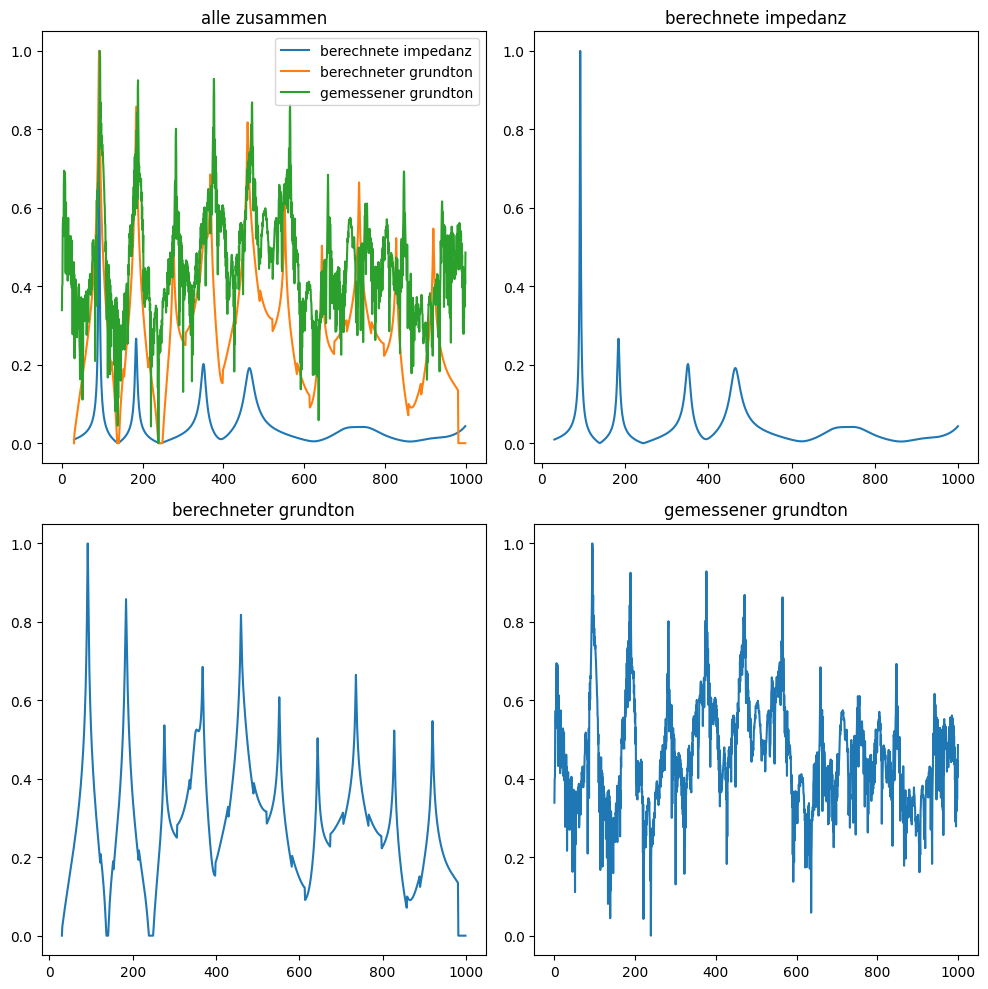

In [441]:
import json

archive_path_json = "../../../../didge-archive/didge-archive.json"
archive_path = os.path.dirname(archive_path_json)
archive = json.load(open(archive_path_json, "r"))

def get_maxima(freq, signal, n):
    
    if type(freq) is not np.array:
        freq = np.array(freq)
    if type(signal) is not np.array:
        signal = np.array(signal)
    
    max_indizes = np.array(argrelextrema(signal, np.greater)[0])
    max_indizes = sorted(max_indizes, key=lambda x : signal[x])
    i_maxima = max_indizes[-1*n:]
    maxima = [freq[m] for m in i_maxima]
    #maxima = sorted(maxima)
    return maxima, i_maxima

def difference_plot(sound_file : str, geo : list, didge_name=None):
    
    geo = Geo(geo)
    cadsd = geo.get_cadsd()

    ground_spektrum=cadsd.get_ground_spektrum()
    ground_freqs = np.array(list(ground_spektrum.keys()))
    ground_vols = np.array(list(ground_spektrum.values()))
    ground_vols -= ground_vols.min()
    ground_vols /= ground_vols.max()
    
    impedance_spektrum = cadsd.get_impedance_spektrum()
    impedance_freqs = impedance_spektrum.freq
    impedance_amps = impedance_spektrum.impedance
    
    impedance_amps -= impedance_amps.min()
    impedance_amps /= impedance_amps.max()

    freq, fft_spectrum_abs = do_fft(sound_file)
    fft_spectrum_abs = np.log2(fft_spectrum_abs)
    fft_spectrum_abs -= fft_spectrum_abs.min()
    fft_spectrum_abs /= fft_spectrum_abs.max()
    
    fig, axs = plt.subplots(2, 2, figsize=(10,10))
    
    axs[0,0].plot(impedance_freqs, impedance_amps, label="berechnete impedanz")
    axs[0,0].plot(ground_freqs, ground_vols, label="berechneter grundton")
    axs[0,0].plot(freq, fft_spectrum_abs, label="gemessener grundton")
    axs[0,0].set_title("alle zusammen")
    axs[0,0].legend()
    
    axs[0,1].plot(impedance_freqs, impedance_amps)
    axs[0,1].set_title("berechnete impedanz")
    
    axs[1,0].plot(ground_freqs, ground_vols)
    axs[1,0].set_title("berechneter grundton")
    
    axs[1,1].plot(freq, fft_spectrum_abs)
    axs[1,1].set_title("gemessener grundton")

    #maxima, i_maxima = get_maxima(freq, fft_spectrum_abs, 12)
    #for m in maxima:
    #    axs[1,1].axvline(x=m, color="red")    
    
    

    fig.tight_layout()

    
didge = archive[0]
geo = json.load(open(os.path.join(archive_path, didge["geometry"]), "r"))
sound_file = os.path.join(archive_path, didge["audio-samples"]["neutral-sound"])

print(didge["name"])
difference_plot(sound_file, geo, didge_name=didge["name"])    

In [438]:
#def window_average(fft_spectrum, window_size = 40 ):
#    
#    #averaged_fft_spectrum = list(fft_spectrum[0:window_size])
#    averaged_fft_spectrum = []
#    for i in range(len(fft_spectrum)):
#        window_i1 = np.max((0, i-window_size))
#        window_i2 = np.min((len(fft_spectrum), i+window_size))
#        window = fft_spectrum[window_i1:window_i2]
#        avg = np.mean(window)
#        averaged_fft_spectrum.append(avg)
#    averaged_fft_spectrum = np.array(averaged_fft_spectrum)
#    return averaged_fft_spectrum

def window_average(freq, fft_spectrum, window_size = 0.1 ):
    averaged_fft_spectrum = []
    _freq = freq.copy()
    zeros = _freq==0
    _freq[zeros] = 0.00000000000001
    log_freq = np.log2(_freq)
    log_freq[zeros] = 0
    for i in range(len(fft_spectrum)):
        window = (log_freq>log_freq[i]-window_size) & (log_freq<log_freq[i]+window_size)
        avg = np.mean(fft_spectrum[window])
        avg = np.mean(window)
        averaged_fft_spectrum.append(avg)
    averaged_fft_spectrum = np.array(averaged_fft_spectrum)
    return averaged_fft_spectrum


# retrieve all local maxima 
# also merge maxima that are close to each other
def get_maxima(freq, averaged_fft_spectrum, min_freq):
    i_maxima = argrelextrema(averaged_fft_spectrum, np.greater)[0]
    
    #i_maxima = sorted(i_maxima, key=lambda i:averaged_fft_spectrum[i])
    i_maxima = np.array(i_maxima)
    
    print(i_maxima)
    print(averaged_fft_spectrum)
    maxima = freq[i_maxima]
    maxima = maxima[maxima>min_freq]
    log_max = np.log2(maxima)

    counter=0
    len_clusters_before = -1
    while not stop:
        counter+=1
        if counter==200:
            break

        distance_matrix = []
        for y in range(len(log_max)):
            row = []
            for x in range(len(log_max)):
                row.append(np.abs(log_max[x] - log_max[y]))
            distance_matrix.append(row)    
        distance_matrix = np.array(distance_matrix)

        clusters = []
        for i in range(len(distance_matrix)):
            c = np.arange(len(distance_matrix))[distance_matrix[i]<0.1]
            clusters.append(c)

        clusters = {str(c):c for c in clusters}.values() # duplicate removal
        clusters = list(clusters)

        for i in range(len(clusters)):
            cluster_amplitudes = averaged_fft_spectrum[i_maxima[clusters[i]]]
            max_i = np.argmax(cluster_amplitudes)
            clusters[i] = clusters[i][max_i]

        clusters=np.array([int(x) for x in clusters])

        maxima = maxima[clusters]
        log_max = np.log2(maxima)

        if len_clusters_before == len(clusters):
            break
        len_clusters_before = len(clusters)

    return maxima
      
freq, fft_spectrum = do_fft(sound_file)
fft_spectrum = np.log2(fft_spectrum)
fft_spectrum -= fft_spectrum.min()
fft_spectrum /= fft_spectrum.max()

averaged_fft_spectrum = window_average(freq, fft_spectrum, window_size=0.1)
#averaged_fft_spectrum = fft_spectrum
freq = np.array(freq)
maxima = get_maxima(freq, averaged_fft_spectrum, 60)
freq = np.array(freq)

plt.plot(freq, fft_spectrum_abs, label="normal")
plt.plot(freq, averaged_fft_spectrum, label="averaged")
plt.legend()

for m in maxima:
    plt.axvline(x=m, color="red")    


[]
[0.00055157 0.00055157 0.00055157 ... 0.06839493 0.06784335 0.06729178]


IndexError: arrays used as indices must be of integer (or boolean) type

In [429]:
def window_average(freq, fft_spectrum, window_size = 0.1 ):
    averaged_fft_spectrum = []
    _freq = freq.copy()
    zeros = _freq==0
    _freq[zeros] = 1
    log_freq = np.log2(_freq)
    log_freq[zeros] = 0
    for i in range(len(fft_spectrum)):
        window = (log_freq>log_freq[i]-window_size) & (log_freq<log_freq[i]+window_size)
        avg = np.mean(fft_spectrum[window])
        avg = np.mean(window)
        averaged_fft_spectrum.append(avg)
    averaged_fft_spectrum = np.array(averaged_fft_spectrum)
    return averaged_fft_spectrum


freq, fft_spectrum = do_fft(sound_file)
fft_spectrum = np.log2(fft_spectrum)
fft_spectrum -= fft_spectrum.min()
fft_spectrum /= fft_spectrum.max()

averaged_fft_spectrum = window_average(freq, fft_spectrum)
freq = np.array(freq)
maxima = get_maxima(freq, averaged_fft_spectrum, 60)
freq = np.array(freq)

i = (freq>30) & (freq<90)
plt.plot(freq[i], fft_spectrum_abs[i], label="normal")
plt.plot(freq[i], averaged_fft_spectrum[i], label="averaged")
plt.legend()



[]


IndexError: arrays used as indices must be of integer (or boolean) type

In [386]:
window_size=0.1
averaged_fft_spectrum = []
log_freq = np.log2(freq)
for i in range(len(freq)):

    center_freq = log_freq[i]
    i_window = (log_freq>center_freq-window_size) & (log_freq<center_freq+window_size)
    #window_i1 = np.max((0, i-window_size))
    #window_i2 = np.min((len(fft_spectrum), i+window_size))
    #window = fft_spectrum[window_i1:window_i2]
    #avg = np.mean(window)
    avg = np.mean(fft_spectrum[i_window])
    if i==50:
        print(i_window.astype(int).sum())
        break


7


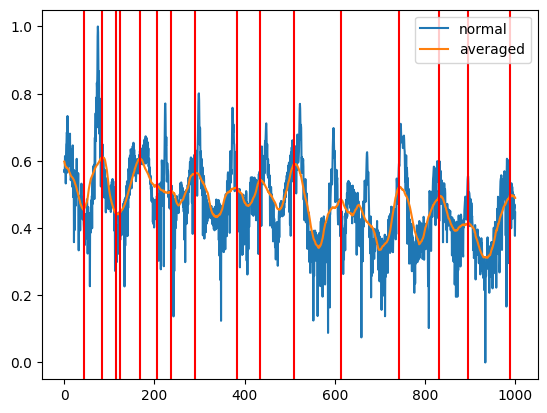

In [335]:
averaged_fft_spectrum = window_average(fft_spectrum)
freq = np.array(freq)
maxima = get_maxima(freq, averaged_fft_spectrum)
freq = np.array(freq)

#averaged_fft_spectrum = window_average(fft_spectrum, window_size=10)

plt.plot(freq, fft_spectrum, label="normal")
plt.plot(freq, averaged_fft_spectrum, label="averaged")
plt.legend()

for m in maxima:
    plt.axvline(x=m, color="red")    


[array([0]), array([1, 2]), array([3, 4])]

In [117]:
from sklearn.cluster import KMeans
import numpy as np

X = np.array(maxima).reshape(-1,1)
kmeans = KMeans(n_clusters=10, random_state=0, n_init="auto").fit(X)
kmeans.labels_

#colors = ""
#kmeans.predict([[0, 0], [12, 3]])
#kmeans.cluster_centers_



array([7, 5, 5, 5, 5, 5, 5, 1, 1, 1, 8, 8, 8, 9, 0, 0, 0, 4, 4, 2, 4, 2,
       4, 4, 4, 6, 2, 2, 3, 3], dtype=int32)